In [1]:
import pandas as pd
import datasets
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from backend.training.data_utils import create_dataset
from functools import partial


CACHE_DIR = 'data'

## About data

**Named Entity Recognition in Twitter: A Dataset and Analysis on Short-Term Temporal Shifts, AACL main conference 2022**

NER dataset on Twitter with 7 entity labels. Each instance of TweetNER7 comes with a timestamp which distributes from September 2019 to August 2021.

Entity Types: 
* corperation, 
* creative_work, 
* event, 
* group, 
* location, 
* product, 
* person

## Loading datasets

In [2]:
all_datasets = datasets.load_dataset('tner/tweetner7', cache_dir=CACHE_DIR)
train_dataset = all_datasets['train_all']
val_dataset = datasets.concatenate_datasets([all_datasets[ 'validation_2020'], all_datasets['validation_2021']])
test_dataset = datasets.concatenate_datasets([all_datasets['test_2020'], all_datasets['test_2021']])

In [3]:
label_2_id = {
                 "B-corporation": 0,
                 "B-creative_work": 1,
                 "B-event": 2,
                 "B-group": 3,
                 "B-location": 4,
                 "B-person": 5,
                 "B-product": 6,
                 "I-corporation": 7,
                 "I-creative_work": 8,
                 "I-event": 9,
                 "I-group": 10,
                 "I-location": 11,
                 "I-person": 12,
                 "I-product": 13,
                 "O": 14
             }

id_2_label = {v: k for k, v in label_2_id.items()}

labels_list = ['corporation', 'creative_work', 'event', 'group', 'location', 'person', 'product']
global_metrics = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

def to_bio(row, labels_mapping: dict):
    bio_labels = []
    for label in row['tags']:
        bio_labels.append(labels_mapping[label])
    row['bio_labels'] = bio_labels
    return row

converter_fn = partial(to_bio, labels_mapping={v: k for k, v in label_2_id.items()})
train_dataset = train_dataset.map(converter_fn)
val_dataset = val_dataset.map(converter_fn)
test_dataset = test_dataset.map(converter_fn)

## General Data Description

First, let's examine what texts and their annotation looks like

In [4]:
num_examples = 5
for document in range(num_examples):
  # beginning = random.randint(0, len(train_data.tokens[document]) - 16)
  beginning = 0
  ending = beginning + 20

  print(f'Document {document}, tokens from {beginning} to {ending}:')
  print(
      pd.DataFrame(
          {
              'tokens:': train_dataset["tokens"][document][beginning:ending],
              'tags:': list(map(lambda x: id_2_label[x], train_dataset["tags"][document][beginning:ending])),
          }
      )
      .transpose()
      .to_string(index=True, header=False),
      '\n'
  )

Document 0, tokens from 0 to 20:
tokens:  Morning  5km  run  with  {{USERNAME}}  for  breast  cancer  awareness  #  pinkoctober  #  breastcancerawareness  #  zalorafit  #  zalorafitxbnwrc  @  The     Central
tags:          O    O    O     O             O    O       O       O          O  O      B-event  O                B-event  O          O  O                O  O    O  B-location 

Document 1, tokens from 0 to 20:
tokens:  President     Trump  Arrives  at            UFC            244  in         New        York  to  Cheers  from  Crowd  (  VIDEO  )  {{URL}}  via  {{USERNAME}}
tags:     B-person  I-person        O   O  B-corporation  I-corporation   O  B-location  I-location   O       O     O      O  O      O  O        O    O             O 

Document 2, tokens from 0 to 20:
tokens:  "  I  've  been  in  law  enforcement  for  23  years  .  I  've  never  seen  this  in  this  city  and
tags:    O  O    O     O   O    O            O    O   O      O  O  O    O      O     O     O   O     

To gain a better insight into the meaning of each category, let's draw a few examples:

In [5]:
train_df = pd.DataFrame(train_dataset)
train_df['labels'] = train_df.tags.apply(lambda text: [id_2_label[token] for token in text])

In [6]:
labels = set([
    label.split('-')[-1]
    for annot in train_df.labels
    for label in annot
]) - {'O'}


def get_examples(label: str, num_examples: int):
  examples = []
  for document in range(0, train_df.shape[0]):
    if len(examples) >= num_examples:
      return examples
    try:
      beginning = train_df.labels[document].index(f'B-{label}')
    except ValueError:
      continue

    example = train_df.tokens[document][beginning].strip()
    for token_id in range(beginning + 1, len(train_df.tokens[document]) - 1):
      if train_df.labels[document][token_id] == f'I-{label}':
        example += ' ' + train_df.tokens[document][token_id].strip()
    examples.append(example)

  print(f'WARNING: could not find {num_examples} examples for label {label}, found {len(examples)} examples')
  return examples


label_examples = {}
for label in labels:
  label_examples[label] = get_examples(label=label, num_examples=10)

In [7]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in label_examples.items()])).T

,0,1,2,3,4,5,6,7,8,9
group,Rams,Lavanderboyz chillcast,StrayKidsComback,{@One Direction@},BROWNS,Lakers,Hurricane Center,"{@Higher Education Department, MP@}",Liverpool Vs Man United,Thecollaroyboys
location,"Central Park , Desa Parkcity",New York,Salo,Uplands Parks,NYC,{@St. Lawrence College@},Japan Africa,Louisiana coast,The Irish Corner Limited,UK-based
corporation,UFC 244,Buffalo Police,Eyewitness News WTVO WQRF,{@SERA - Labour's Environment Campaign@},twitch,iTunes,{@Global Kingston@},MMA,Blue Mountains,NBA
event,pinkoctober,Buffalo,3-nations final game,fringe event,Smallstreamerconnect,Christmas parties Christmas,Bball,{@Rugby World Cup@},thanksgiving,climatechange
product,{@Google News@},Mayo Breast Cancer Vaccine,{@YouTube@},floorball,Red and Green Festive Color Badges,{@DistroKid@},recording,CUSTOM BROWNS ATTIRE,Social Security Fund,{@CBS News@}
person,President Trump,Jeff Rinaldo,Bart,{@Daniel Zeichner@},Trump,Popsd,SadGuru Ji Maharaj,Goff,{@Chadwick Boseman@},{@Carla Esparza@}
creative_work,Itchy and Scratchy Simpsons Simpsons,Supporting Nature,Warzone,Make Christmas Great Again 6-Pack Buttons,Above the Rain,Star Wars,Probe the Act 2,ship,AfterLife,His fights


## Quantitative description

### Length distribution

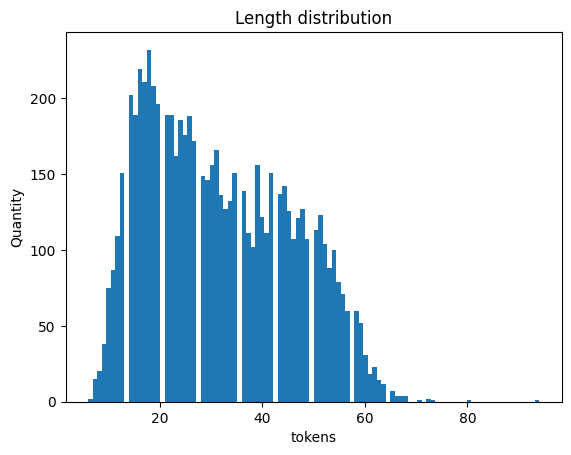

In [8]:
train_df.tokens.apply(len).plot.hist(title='Length distribution', xlabel='tokens', ylabel='Quantity', bins=100);

In [9]:
train_df["labels"] = train_df.labels.apply(lambda text: [i.split('-')[-1] if not i == 'O' else i for i in text])

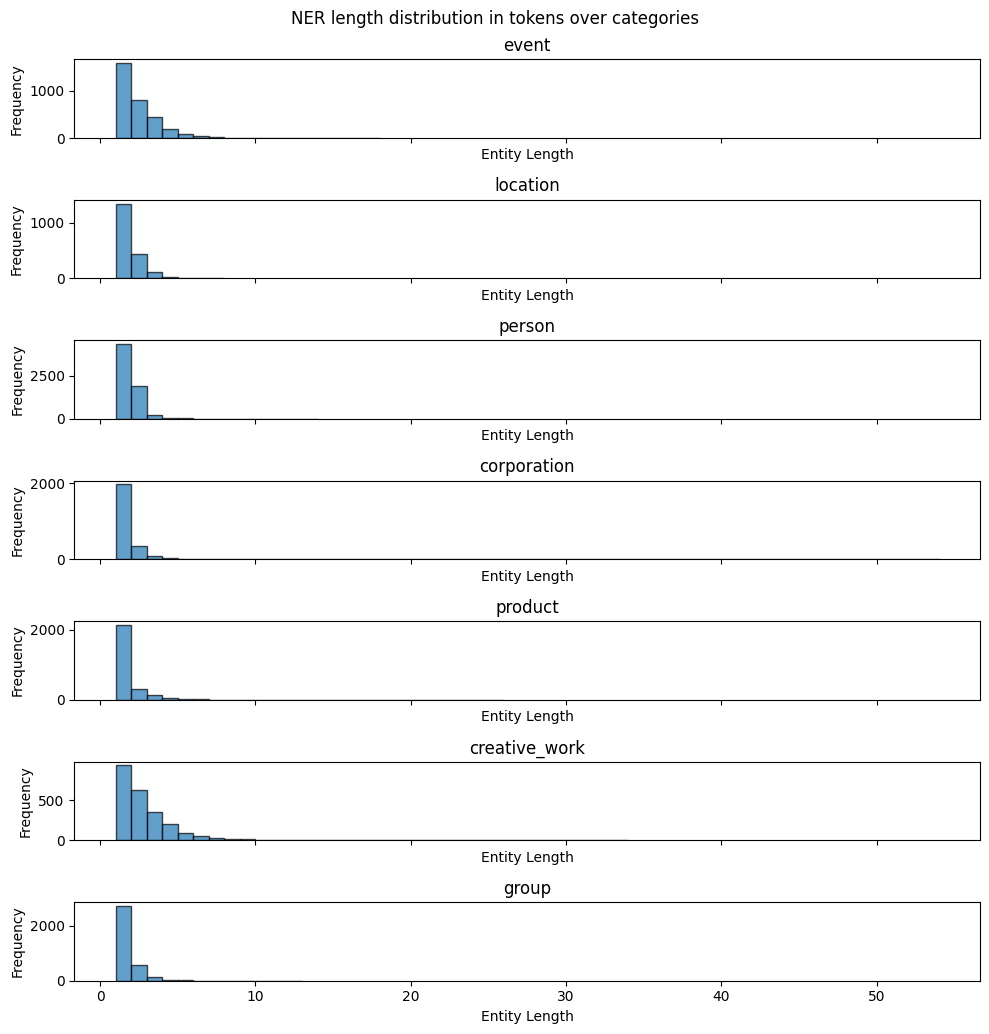

In [10]:
from collections import defaultdict

def extract_entities(tokens, labels):
    entities = defaultdict(list)
    current_entity = []
    current_label = None

    for token, label in zip(tokens, labels):
        if label != 'O':
            if not current_entity or label != current_label:
                if current_entity:
                    entities[current_label].append(len(current_entity))
                current_entity = [token]
                current_label = label
            else:
                current_entity.append(token)
        else:
            if current_entity:
                entities[current_label].append(len(current_entity))
                current_entity = []
                current_label = None

    if current_entity:
        entities[current_label].append(len(current_entity))

    return entities

all_entities = defaultdict(list)
for _, row in train_df.iterrows():
    entities = extract_entities(row['tokens'], row['labels'])
    for entity_type, lengths in entities.items():
        all_entities[entity_type].extend(lengths)


num_categories = len(all_entities)
fig, axes = plt.subplots(nrows=num_categories, ncols=1, figsize=(10, 1.5 * num_categories), sharex=True)

for ax, (entity_type, lengths) in zip(axes, all_entities.items()):
    ax.hist(lengths, bins=range(1, max(lengths)+2), alpha=0.7, edgecolor='black')
    ax.set_title(entity_type)
    ax.set_xlabel('Entity Length')
    ax.set_ylabel('Frequency')

fig.suptitle('NER length distribution in tokens over categories')
plt.tight_layout()
plt.show()

Longer entities typically tend to be events and creative work. On the contrary, "corporation" and "location" categories less often have big number of tokens.

### How many tokens belong to NER?

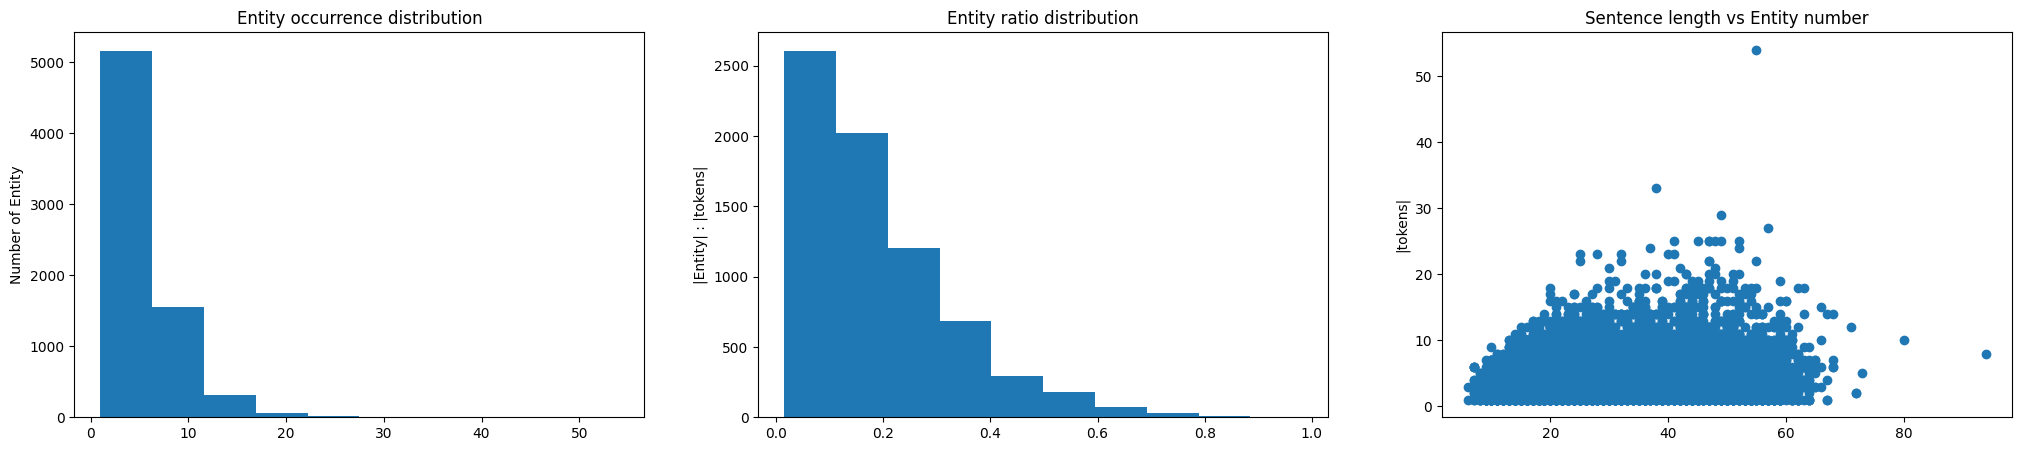

In [11]:

non_pii_count = train_df.labels.apply(lambda x: x.count('O'))
pii_count = train_df.labels.apply(len) - non_pii_count
pii_ratio = pii_count / train_df.labels.apply(len)


fig, axes = plt.subplots(1, 3, figsize=(25, 5))
axes[0].hist(pii_count)
axes[0].set_title('Entity occurrence distribution')
axes[0].set_ylabel('Number of Entity')

axes[1].hist(pii_ratio)
axes[1].set_title('Entity ratio distribution')
axes[1].set_ylabel('|Entity| : |tokens|')

axes[2].scatter(train_df.labels.apply(len), pii_count)
axes[2].set_title('Sentence length vs Entity number')
axes[2].set_ylabel('|Entity|')
axes[2].set_ylabel('|tokens|')

plt.show()

In [12]:
import numpy as np

print('Среднее количество сущностей в тексте:', pii_count.mean(), 'Максимальное количество: ', pii_count.max())
print('Коэффициент корреляции длины и кол-ва NE:', np.corrcoef(pii_count, train_df.labels.apply(len))[0, 1])

Среднее количество сущностей в тексте: 5.081001265644776 Максимальное количество:  54
Коэффициент корреляции длины и кол-ва NE: 0.15969080426696736


In about half of the cases, entities make up about half of all tokens. 

Expectedly, the longer the text, the more entities it may contain. However, after a certain length threshold (around 15 tokens), the rate of NER ratio increase slows down. 

### Categories distribution

In [13]:
id_2_label = {v: k.split('-')[-1] for k, v in label_2_id.items() if k.startswith('B')}

def plot_categ_distribution(data, ax, title):
    labels_dict = dict(zip(labels_list, [0] * len(labels_list)))

    def count_labels(row):
        for token in row['tags']:
            if token in id_2_label:
                labels_dict[id_2_label[token]] += 1

    data.map(count_labels)
    ax.bar(labels_dict.keys(), labels_dict.values())
    ax.set_title(title)

Map:   0%|          | 0/7111 [00:00<?, ? examples/s]

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Map:   0%|          | 0/3383 [00:00<?, ? examples/s]

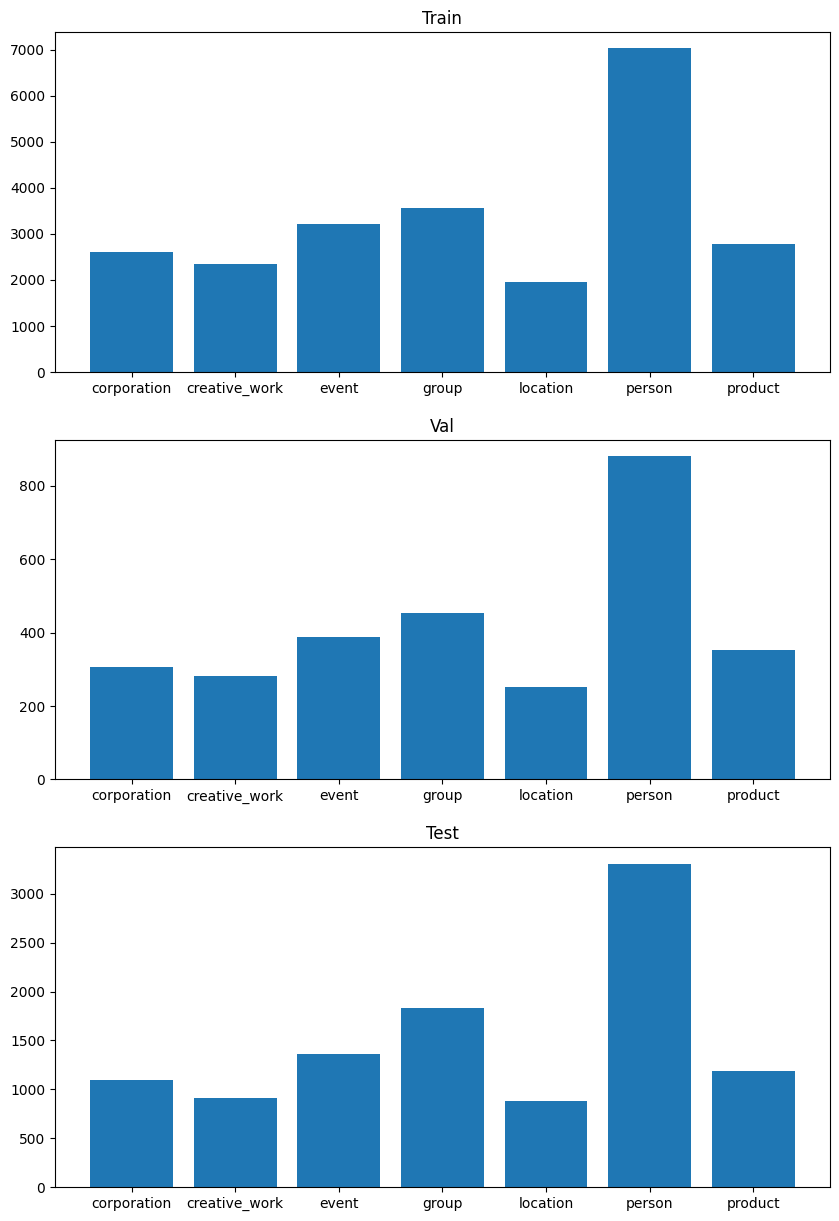

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

plot_categ_distribution(train_dataset, axes[0], 'Train')
plot_categ_distribution(val_dataset, axes[1], 'Val')
plot_categ_distribution(test_dataset, axes[2], 'Test')

As we can see, distribution of categories imbalanced, but equal for all data subsets.

### Which entities tend to co-occur more often?

7111it [00:00, 8336.75it/s]


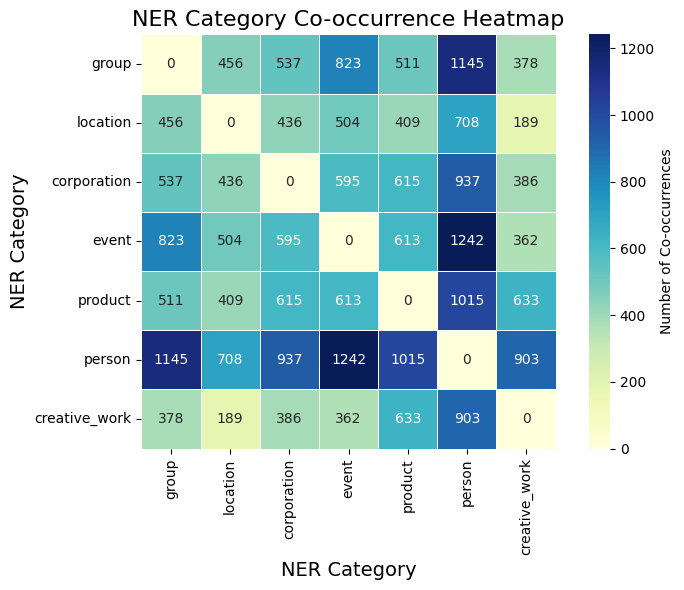

In [15]:
import seaborn as sns
from tqdm import tqdm

categories = list(labels)


def plot_cooccurrence(data: pd.DataFrame) -> None:
    co_occurrence = pd.DataFrame(0, index=categories, columns=categories)

    for _, row in tqdm(data.iterrows()):
        sentence_labels = set(label.split('-')[-1] for label in row['labels'] if label != 'O')
        for cat1 in sentence_labels:
            for cat2 in sentence_labels:
                if cat1 == cat2:
                    continue
                if cat1 in categories and cat2 in categories:
                    co_occurrence.loc[cat1, cat2] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(co_occurrence, annot=True, cmap="YlGnBu", fmt="d", square=True,
                cbar_kws={'label': 'Number of Co-occurrences'}, linewidths=0.5)
    plt.title("NER Category Co-occurrence Heatmap", fontsize=16)
    plt.xlabel("NER Category", fontsize=14)
    plt.ylabel("NER Category", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_cooccurrence(train_df)

We see that "person" often co-occurs with "group" and "events", and a little less often with "product".
"Creative work" and "location" rarely ever meet in the same text. 

### POS description

In [88]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_sm")

docs = train_df.tokens.apply(lambda tokens: nlp(Doc(nlp.vocab, tokens)))

In [90]:
from collections import defaultdict
import seaborn as sns

def extract_pos_distribution(data: pd.DataFrame,
                             preds: list[spacy.tokens.Doc]) -> defaultdict:
  pos_distribution = defaultdict(lambda: defaultdict(int))
  pos_tags = [[token.pos_ for token in document] for document in preds]
  for idx, row in data.iterrows():
      for token, label, pos in zip(row['tokens'], row['labels'], pos_tags[idx]):
          if label != 'O':
              entity_type = label.split('-')[-1]
              pos_distribution[entity_type][pos] += 1

  return pos_distribution


def visualize_pos_distribution(pos_distribution: defaultdict) -> None:
  pos_df = pd.DataFrame(pos_distribution).fillna(0).T.astype(int)
  plt.figure(figsize=(14, 10))
  sns.heatmap(pos_df, annot=True, fmt="d", cmap="Blues",
              cbar_kws={'label': 'Frequency'}, linewidths=0.5,
              annot_kws={"size": 10})

  plt.title("PoS Distribution for each NER Category", fontsize=16)
  plt.ylabel("NER Categories", fontsize=14)
  plt.xlabel("POS Tags", fontsize=14)
  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

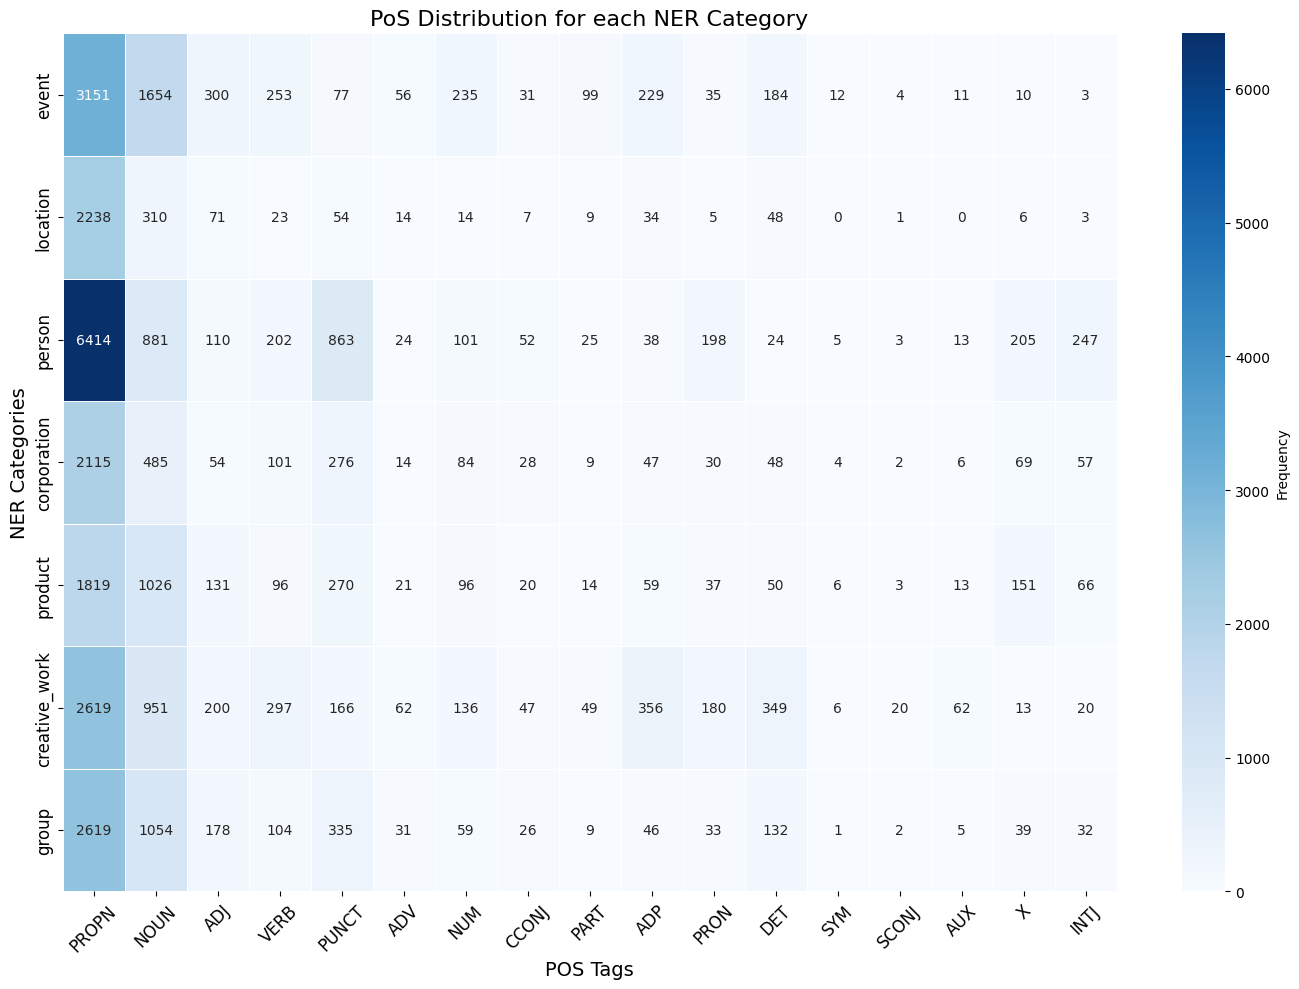

In [91]:
train_pos_distr = extract_pos_distribution(train_df, docs)
visualize_pos_distribution(train_pos_distr)

The vast majority of named entities have proper nouns in them, but it is especially prominent in NERs of the type "person". Second most common across all categories part of speech is noun.
Punctuation is more often present in "person" entities. Aspositions and articles can me a marker for creative work.

## Model training

In [4]:
import evaluate
from easydict import EasyDict

from backend.model_utils import create_model
from backend.training.data_utils import create_dataset, DataCollator, NERDataset
from backend.training.training_utils import Trainer
from backend.training.validation_utils import inference

import os

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Модификация токенизации
#### В датасете ссылки и неизвестные юзернеймы помечены специальными токенами {{URL}} и {{USERNAME}}. Известные юзернеймы помечены токенами {@ и @} в начале и в конце. Добавим эти новые токены в модель, для того, чтобы она считала их отдельными смысловыми единицами.

In [4]:
def get_model_and_tokenizer(model_name: str, extra_labels=None):
    model = create_model(model_name, label_2_id, extra_labels)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, clean_up_tokenization_spaces=False)
    tokenizer.add_tokens(["{{URL}}", "{{USERNAME}}", "{@", "@}"])
    model.resize_token_embeddings(len(tokenizer))
    return model, tokenizer

#### Код обучения и инференса

In [18]:
all_experiments = {}

def plot_loss(losses: list, val_losses: list, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    epochs = list(range(1, len(losses) + 1))
    axes[0].plot(epochs, losses)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')

    val_every = len(losses) // len(val_losses)
    axes[1].plot(epochs[val_every - 1::val_every], val_losses)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    plt.savefig(os.path.join(save_path, 'losses.png'))

def calculate_metrics(predictions: list[str], labels: list[str]):
    metric = evaluate.load("seqeval")
    predictions_adj = [predictions[i] for i in range(len(predictions)) if len(predictions[i]) == len(labels[i])]
    labels_adj = [labels[i] for i in range(len(labels)) if len(predictions[i]) == len(labels[i])]
    metrics = metric.compute(predictions=list(predictions_adj), references=labels_adj)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    print(pd.DataFrame(metrics_class), '\n')
    print(pd.DataFrame([metrics_global], columns=list(metrics_global.keys()), index=['Value']))
    return metrics_class, metrics_global

def create_datasets(tokenizer, save_path):
    os.makedirs(os.path.join(CACHE_DIR, save_path), exist_ok=True)
    train_dataset_tokenized = create_dataset(train_dataset, os.path.join(CACHE_DIR, save_path, 'train_all_tokenized.csv'), tokenizer, max_len=128)
    val_dataset_tokenized = create_dataset(val_dataset, os.path.join(CACHE_DIR, save_path, 'val_all_tokenized.csv'), tokenizer, max_len=128)
    return train_dataset_tokenized, val_dataset_tokenized
    
def get_dataloaders(tokenizer, train_ner_dataset, val_ner_dataset):
    collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
    train_dataloader = DataLoader(train_ner_dataset, batch_size=32, shuffle=True, collate_fn=collator, drop_last=True)
    val_dataloader = DataLoader(val_ner_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)
    return train_dataloader, val_dataloader

def train(model, train_dataloader, val_dataloader, save_path, training_args):
    optimizer = AdamW(model.parameters(), lr=training_args.lr, weight_decay=training_args.weight_decay)

    warmup_steps =  training_args.warmup_ratio * training_args.epochs * len(train_dataloader)
    scheduler = training_args.scheduler_fn(optimizer, warmup_steps, training_args.epochs * len(train_dataloader))
    
    trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                      device=device, scheduler=scheduler, loss_weights=training_args.get('loss_weights', None))
    
    losses, val_losses  = trainer.train(training_args.epochs, save_path, val_every=1)
    return losses, val_losses

def infer_model(model, tokenizer, val_ner_dataset, word_inds):
    collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
    val_dataloader = DataLoader(val_ner_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
    model_preds = inference(model, val_dataloader, word_inds, {v: k for k, v in label_2_id.items()}, device=device)
    return model_preds

def run_experiment(model_name: str, save_path: str, training_args: EasyDict):
    model, tokenizer = get_model_and_tokenizer(model_name)
    
    train_dataset_tokenized, val_dataset_tokenized = create_datasets(tokenizer, save_path)
    train_ner_dataset = NERDataset(train_dataset_tokenized)
    val_ner_dataset = NERDataset(val_dataset_tokenized)
    train_dataloader, val_dataloader = get_dataloaders(tokenizer, train_ner_dataset, val_ner_dataset)
    
    losses, val_losses = train(model, train_dataloader, val_dataloader, save_path, training_args)
    all_experiments[save_path] = (losses, val_losses)
    plot_loss(losses, val_losses, os.path.join('checkpoints', save_path))
    
    best_model = torch.load(os.path.join('checkpoints', save_path, 'best_model.pth'), weights_only=False).to(device).eval()
    model_preds = infer_model(best_model, tokenizer, val_ner_dataset, val_dataset_tokenized['word_inds'])
    metrics_class, metrics_global = calculate_metrics(model_preds, val_dataset['bio_labels'])
    
    return metrics_class, metrics_global

### Model and hyperparameters search

#### В качестве моделей для экспериментов были выбраны 2 трансформера "google-bert/bert-base-cased" и "distilbert/distilbert-base-cased", где "cased" значит, что заглавные и прописные буквы представлены в модели разными токенами. Это обусловлено спецификой задачи NER, ведь заглавная буква часто является признаком именованной сущности. Первая модель имеет большее количество параметров и более долгое время инференса. Вторая - дистилированная версия первой, она менее тяжёлая и более бытсрая, но показывает сопоставимые результаты на популярных бенчмарках.

In [19]:
train_args = EasyDict({'lr': 2e-5, 'weight_decay': 1e-07, 'epochs': 10, 'warmup_ratio': 0.0, 'scheduler_fn': get_linear_schedule_with_warmup})

#### Попробуем обучить обе модели со стандартными гиперпараметрами для token classification, взятыми из туториала с huggingface.

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Found cached data in data\bert_base_default_hp\train_all_tokenized.csv
Found cached data in data\bert_base_default_hp\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.56it/s]


Epoch: 0, Mean loss: 0.7378909803994059


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.52it/s]


Mean Val loss: 0.5141589045524597


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.72it/s]


Epoch: 1, Mean loss: 0.4688623311283351


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.43it/s]


Mean Val loss: 0.47505722727094374


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.64it/s]


Epoch: 2, Mean loss: 0.3893063748339274


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.29it/s]


Mean Val loss: 0.46255127659865775


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.66it/s]


Epoch: 3, Mean loss: 0.3342090904175699


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.21it/s]


Mean Val loss: 0.478647659931864


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.58it/s]


Epoch: 4, Mean loss: 0.2911662335197132


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.23it/s]


Mean Val loss: 0.4851938656398228


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.62it/s]


Epoch: 5, Mean loss: 0.25543043990661424


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.18it/s]


Mean Val loss: 0.5019210257700512


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.60it/s]


Epoch: 6, Mean loss: 0.22723591106163488


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.18it/s]


Mean Val loss: 0.5390461427824838


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.63it/s]


Epoch: 7, Mean loss: 0.20850062423998175


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.17it/s]


Mean Val loss: 0.5386532970837185


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.63it/s]


Epoch: 8, Mean loss: 0.19370101066725748


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.24it/s]


Mean Val loss: 0.5528455206326076


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.60it/s]


Epoch: 9, Mean loss: 0.1838764491247701


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.14it/s]


Mean Val loss: 0.5559295309441431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 353.77it/s]


           corporation  creative_work       event       group    location  \
precision     0.483776       0.391720    0.369898    0.562780    0.587591   
recall        0.539474       0.436170    0.374677    0.552863    0.636364   
f1            0.510109       0.412752    0.372272    0.557778    0.611006   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.826531    0.655063  
recall       0.827469    0.589744  
f1           0.826999    0.620690  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.600742        0.611264    0.605957          0.910532


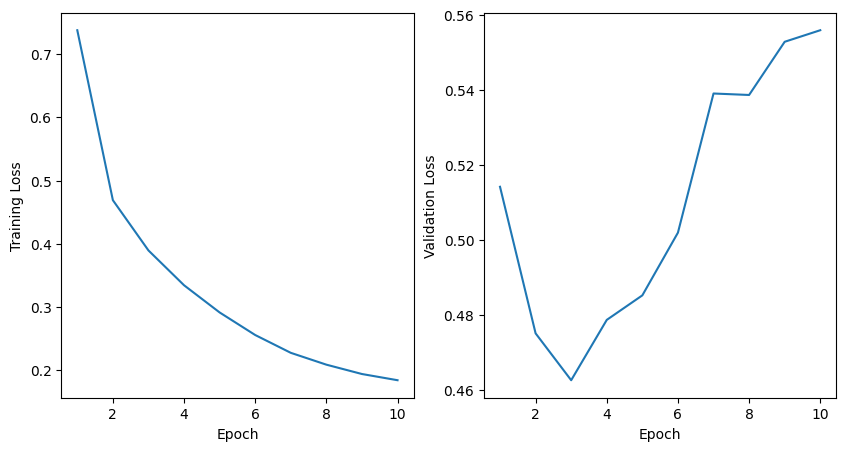

In [20]:
model_name = "google-bert/bert-base-cased"
save_path = "bert_base_default_hp"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\distillbert_base_default_hp\train_all_tokenized.csv
Found cached data in data\distillbert_base_default_hp\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.62it/s]


Epoch: 0, Mean loss: 0.8205194328282331


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.17it/s]


Mean Val loss: 0.5731511712074279


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.72it/s]


Epoch: 1, Mean loss: 0.5234161632823514


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.61it/s]


Mean Val loss: 0.4982688277959824


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.77it/s]


Epoch: 2, Mean loss: 0.44184402369701126


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.76it/s]


Mean Val loss: 0.48220228084496086


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.72it/s]


Epoch: 3, Mean loss: 0.3880550443186415


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.98it/s]


Mean Val loss: 0.4783819445541928


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.81it/s]


Epoch: 4, Mean loss: 0.34732829765962075


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.93it/s]


Mean Val loss: 0.4879264597381864


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.75it/s]


Epoch: 5, Mean loss: 0.3118341923565477


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.76it/s]


Mean Val loss: 0.5002616537468774


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.79it/s]


Epoch: 6, Mean loss: 0.2853696170422408


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.03it/s]


Mean Val loss: 0.5013638670955385


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.85it/s]


Epoch: 7, Mean loss: 0.263087560666037


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.88it/s]


Mean Val loss: 0.5199924877711705


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.89it/s]


Epoch: 8, Mean loss: 0.24655021163257382


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.08it/s]


Mean Val loss: 0.527077195899827


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.96it/s]


Epoch: 9, Mean loss: 0.23777505829259085


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.55it/s]


Mean Val loss: 0.5276283025741576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:01<00:00, 464.96it/s]


           corporation  creative_work       event       group    location  \
precision     0.477352       0.384892    0.320513    0.536866    0.556818   
recall        0.450658       0.379433    0.322997    0.513216    0.581028   
f1            0.463621       0.382143    0.321750    0.524775    0.568665   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.818599    0.661238  
recall       0.809308    0.578348  
f1           0.813927    0.617021  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.588131        0.571772    0.579836          0.906228


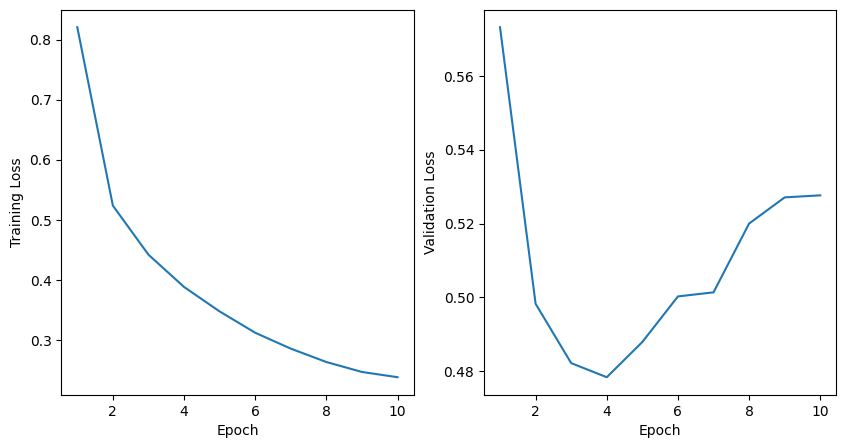

In [21]:
model_name = "distilbert/distilbert-base-cased"
save_path = "distillbert_base_default_hp"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

#### Поскольку обе модели показывают переобучение (валидационный лосс начинает расти уже после 2 и 4 эпох) попробуем уменьшить количество эпох. Также, лосс падает довольно медленно, попробуем увеличить стартовый learning rate. Борьбе с переобучением может поспособствовать увеличенный weight decay.

In [22]:
train_args = EasyDict({'lr': 1e-4, 'weight_decay': 0.05, 'epochs': 4, 'warmup_ratio': 0.0, 'scheduler_fn': get_linear_schedule_with_warmup})

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\bert_base_reduced_ep\train_all_tokenized.csv
Found cached data in data\bert_base_reduced_ep\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:26<00:00,  8.53it/s]


Epoch: 0, Mean loss: 0.5983409140561081


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.23it/s]


Mean Val loss: 0.473966304744993


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.63it/s]


Epoch: 1, Mean loss: 0.3726750149114712


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.15it/s]


Mean Val loss: 0.45934266916343136


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.60it/s]


Epoch: 2, Mean loss: 0.25534171107653014


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.16it/s]


Mean Val loss: 0.4755181946924754


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.58it/s]


Epoch: 3, Mean loss: 0.17138229592426402


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.14it/s]


Mean Val loss: 0.5275593123265676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 358.31it/s]


           corporation  creative_work       event       group    location  \
precision     0.503226       0.424658    0.358354    0.549234    0.600760   
recall        0.513158       0.439716    0.382429    0.552863    0.624506   
f1            0.508143       0.432056    0.370000    0.551043    0.612403   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.836009    0.638484  
recall       0.827469    0.623932  
f1           0.831717    0.631124  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.605085        0.612981    0.609007          0.913402


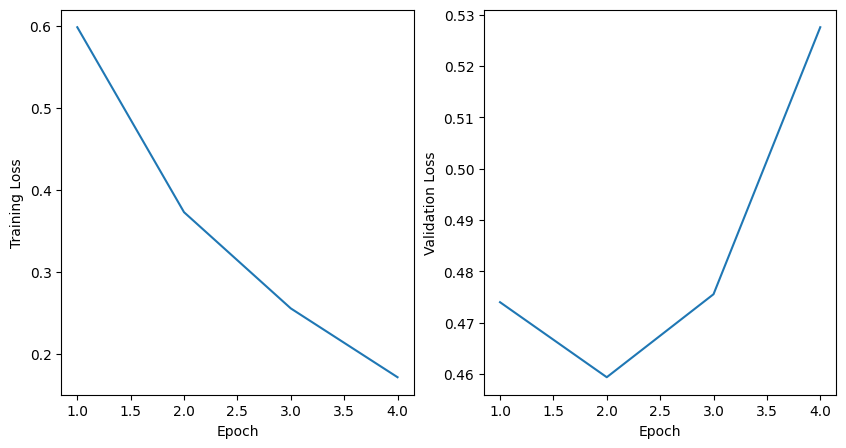

In [23]:
model_name = "google-bert/bert-base-cased"
save_path = "bert_base_reduced_ep"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\distillbert_base_reduced_ep\train_all_tokenized.csv
Found cached data in data\distillbert_base_reduced_ep\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.49it/s]


Epoch: 0, Mean loss: 0.6585316917112285


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.68it/s]


Mean Val loss: 0.4765963405370713


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.84it/s]


Epoch: 1, Mean loss: 0.4021264678454613


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.08it/s]


Mean Val loss: 0.4649140919957842


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.88it/s]


Epoch: 2, Mean loss: 0.2822506345204405


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.07it/s]


Mean Val loss: 0.49094201411519733


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.86it/s]


Epoch: 3, Mean loss: 0.20049010928686672


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.91it/s]


Mean Val loss: 0.5230069458484651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:01<00:00, 659.27it/s]


           corporation  creative_work       event       group    location  \
precision     0.470588       0.403636    0.335092    0.560000    0.578358   
recall        0.500000       0.393617    0.328165    0.524229    0.612648   
f1            0.484848       0.398564    0.331593    0.541524    0.595010   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.815029    0.662338  
recall       0.800227    0.581197  
f1           0.807560    0.619120  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.595146        0.581044     0.58801          0.908523


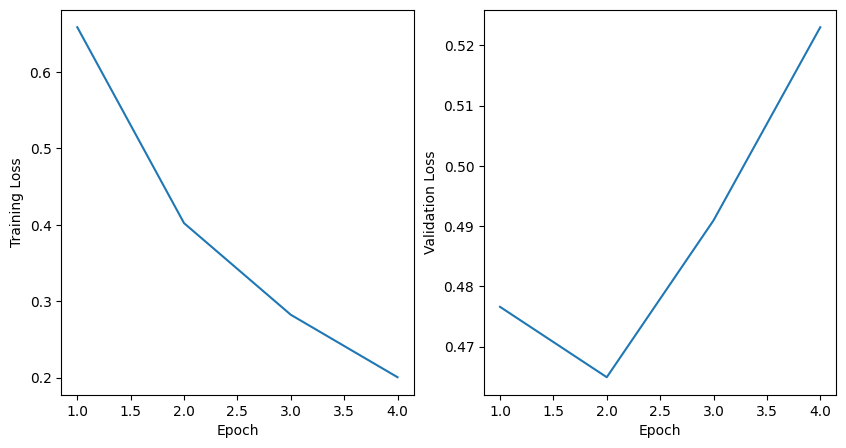

In [24]:
model_name = "distilbert/distilbert-base-cased"
save_path = "distillbert_base_reduced_ep"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

#### С таким набором гиперпараметров переобучение наступает уже после 2 эпох, с улучшением полученных ранее метрик. Ограничим количество эпох 2-мя. Также, добавим warmup для того, чтобы уменьшить влияние пепрвых шагов обучения

In [25]:
train_args = EasyDict({'lr': 1e-4, 'weight_decay': 0.05, 'epochs': 2, 'warmup_ratio': 0.3, 'scheduler_fn': get_linear_schedule_with_warmup})

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\bert_base_warmup\train_all_tokenized.csv
Found cached data in data\bert_base_warmup\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:26<00:00,  8.49it/s]


Epoch: 0, Mean loss: 0.8423160795155942


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.18it/s]


Mean Val loss: 0.46935331395694185


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.59it/s]


Epoch: 1, Mean loss: 0.3884130725720982


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.12it/s]


Mean Val loss: 0.4361064327614647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 356.96it/s]


           corporation  creative_work       event       group    location  \
precision     0.532567       0.506276    0.398058    0.615578    0.599251   
recall        0.457237       0.429078    0.317829    0.539648    0.632411   
f1            0.492035       0.464491    0.353448    0.575117    0.615385   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.835586    0.675497  
recall       0.842225    0.581197  
f1           0.838892    0.624809  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.650901        0.595467    0.621951          0.916703


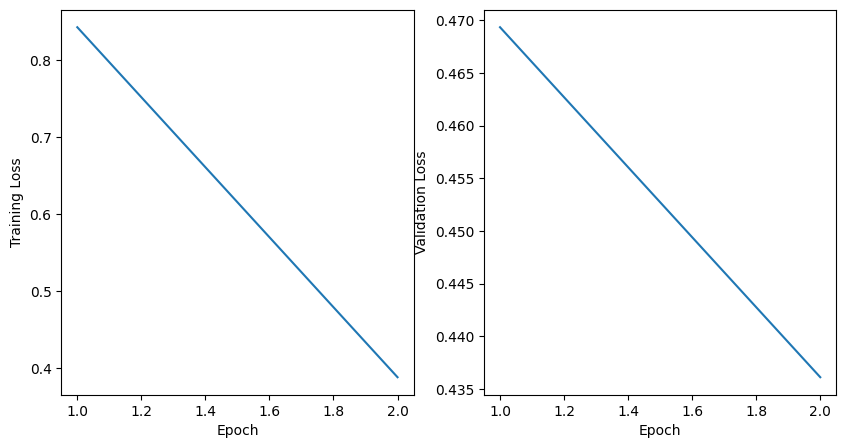

In [26]:
model_name = "google-bert/bert-base-cased"
save_path = "bert_base_warmup"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\distillbert_base_warmup\train_all_tokenized.csv
Found cached data in data\distillbert_base_warmup\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.48it/s]


Epoch: 0, Mean loss: 0.8987893110459987


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.98it/s]


Mean Val loss: 0.5064138493367605


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:13<00:00, 16.94it/s]


Epoch: 1, Mean loss: 0.4199601358792802


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.04it/s]


Mean Val loss: 0.4541189329964774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:01<00:00, 655.91it/s]


           corporation  creative_work       event       group    location  \
precision     0.516667       0.396825    0.393836    0.612903    0.584559   
recall        0.407895       0.354610    0.297158    0.502203    0.628458   
f1            0.455882       0.374532    0.338733    0.552058    0.605714   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.817130    0.677083  
recall       0.801362    0.555556  
f1           0.809169    0.610329  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value            0.63062        0.558723    0.592498          0.910461


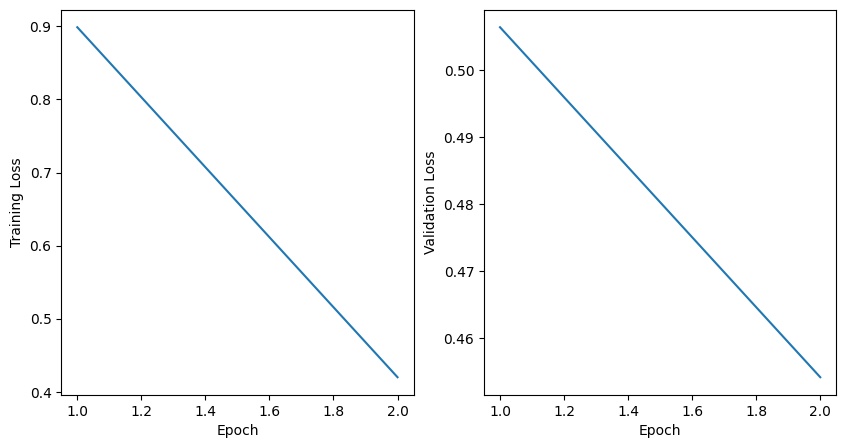

In [27]:
model_name = "distilbert/distilbert-base-cased"
save_path = "distillbert_base_warmup"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

#### Метрики возросли ещё сильнее, всего за 2 эпохи модели достигают хороших резльтатов, сопоставимых с SOTA-моделями для данного датасета. "google-bert/bert-base-cased" показал себя лучше во всех экспериментах, в дальнейшем будет использоваться он.

### Weighted loss
#### Поскольку категории в нашем датасете распределены неравномерно, имеется сильный дисбаланс в метриках между классами. Попробуем использовать взвешенный лосс, для того, чтобы уменьшить влияние часто встречающихся категорий и увеличить влияние редких и плохопредсказываемых. Весами будут являться обратные значения метрик классов, полученные в ходе предыдущих экспериментов.

In [28]:
from collections import OrderedDict


labels_dict = dict(zip(labels_list, [0] * len(labels_list)))

def count_labels(row):
    for token in row['tags']:
        if token in id_2_label:
            labels_dict[id_2_label[token]] += 1

train_dataset.map(count_labels)

all_labels = sum(labels_dict.values())
loss_weights = {k: (1 - metrics_class[k]['f1']).item() for k, v in labels_dict.items()}

loss_weights = {k: loss_weights[k.split('-')[-1]] if k != 'O' else 1.0 for k in label_2_id.keys()}

train_args = EasyDict({'lr': 1e-4, 'weight_decay': 0.05, 'epochs': 2, 'warmup_ratio': 0.3, 'scheduler_fn': get_linear_schedule_with_warmup, 
                       'loss_weights': torch.tensor(list(loss_weights.values()), device=device)})
loss_weights

Map:   0%|          | 0/7111 [00:00<?, ? examples/s]

{'B-corporation': 0.5441176470588235,
 'B-creative_work': 0.6254681647940075,
 'B-event': 0.6612665684830634,
 'B-group': 0.4479418886198546,
 'B-location': 0.39428571428571424,
 'B-person': 0.19083094555873925,
 'B-product': 0.3896713615023474,
 'I-corporation': 0.5441176470588235,
 'I-creative_work': 0.6254681647940075,
 'I-event': 0.6612665684830634,
 'I-group': 0.4479418886198546,
 'I-location': 0.39428571428571424,
 'I-person': 0.19083094555873925,
 'I-product': 0.3896713615023474,
 'O': 1.0}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\bert_base_best_weighted_loss\train_all_tokenized.csv
Found cached data in data\bert_base_best_weighted_loss\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:26<00:00,  8.53it/s]


Epoch: 0, Mean loss: 0.5855769307629479


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.17it/s]


Mean Val loss: 0.308547420161111


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.62it/s]


Epoch: 1, Mean loss: 0.2587873833002268


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.08it/s]


Mean Val loss: 0.2923018634319305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 349.94it/s]


           corporation  creative_work       event       group    location  \
precision     0.511811       0.463320    0.451049    0.664740    0.609562   
recall        0.427632       0.425532    0.333333    0.506608    0.604743   
f1            0.465950       0.443623    0.383358    0.575000    0.607143   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.888451    0.712177  
recall       0.768445    0.549858  
f1           0.824102    0.620579  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.671881         0.56044    0.611122          0.916954


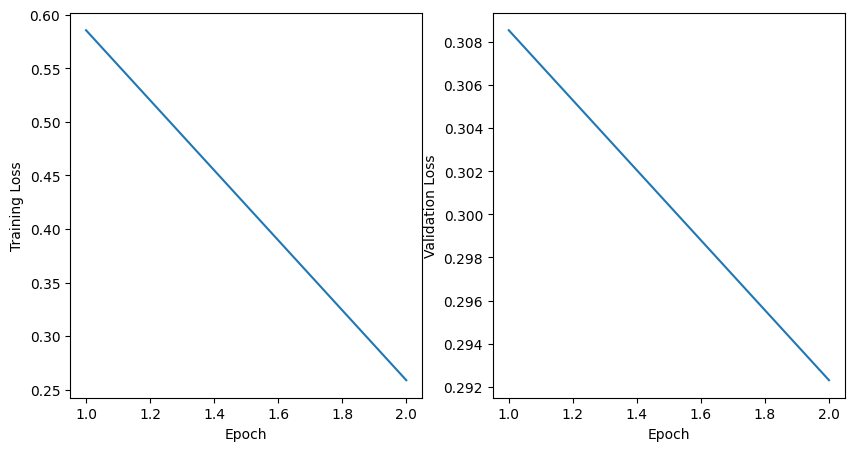

In [29]:
model_name = "google-bert/bert-base-cased"
save_path = "bert_base_best_weighted_loss"

metrics_class, metrics_global = run_experiment(model_name, save_path, train_args)

#### К сожалению, улучшить метрики при помощи взвешенного лосса не удалось, в некоторых категориях метрика улучшается, но, вместе с этим, падает в других

### Extra information
#### Как показал разведочный анализ, знание о части речи, к которой принадлежит токен может помочь определить его отношение к сущности. Добавим информацию о части речи в модель, создав дополнительные эмбеддинги.

In [30]:
def adjust_pos_labels(row):
    pos_labels = []
    for ind in row['word_inds']:
        if ind is not None:
            pos_labels.append(row['extra_labels'][ind])
        else:
            pos_labels.append(0)
    return pos_labels

train_with_pos = pd.read_csv('data/train_data_with_pos_tags.csv')['pos_tags']
val_with_pos = pd.read_csv('data/val_data_with_pos_tags.csv')['pos_tags']

pos_types = pd.read_csv('pos_tags.csv', header=None).iloc[:, 0]
pos_2_id = {pos: i for i, pos in enumerate(pos_types)}

transform = lambda row: [pos_2_id[elem] for elem in eval(row)]

train_with_pos = train_with_pos.apply(transform)
val_with_pos = val_with_pos.apply(transform)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found cached data in data\bert_base_pos_tags\train_all_tokenized.csv
Found cached data in data\bert_base_pos_tags\val_all_tokenized.csv
Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:26<00:00,  8.44it/s]


Epoch: 0, Mean loss: 0.8644822857401396


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 12.99it/s]


Mean Val loss: 0.5179165112120765


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:25<00:00,  8.54it/s]


Epoch: 1, Mean loss: 0.4562223197909089


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 12.98it/s]


Mean Val loss: 0.45566555219037186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 343.54it/s]


           corporation  creative_work       event       group    location  \
precision     0.542017       0.420000    0.361022    0.586902    0.562016   
recall        0.424342       0.372340    0.291990    0.513216    0.573123   
f1            0.476015       0.394737    0.322857    0.547591    0.567515   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.815242    0.645161  
recall       0.801362    0.569801  
f1           0.808243    0.605144  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.619681        0.560096    0.588384          0.911788


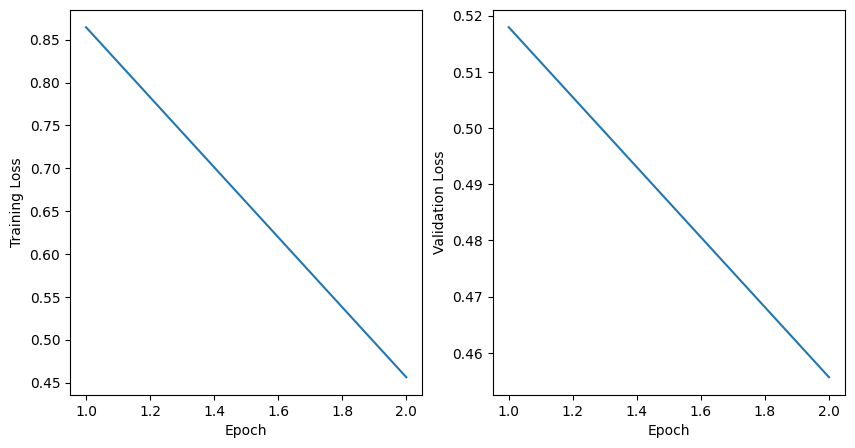

In [31]:
training_args = EasyDict({'lr': 1e-4, 'weight_decay': 0.05, 'epochs': 2, 'warmup_ratio': 0.3, 'scheduler_fn': get_linear_schedule_with_warmup})

save_path = 'bert_base_pos_tags'
model_name = "google-bert/bert-base-cased"

model, tokenizer = get_model_and_tokenizer(model_name, extra_labels=len(pos_types))
    
train_dataset_tokenized, val_dataset_tokenized = create_datasets(tokenizer, save_path)

train_dataset_tokenized['extra_labels'] = train_with_pos
val_dataset_tokenized['extra_labels'] = val_with_pos

train_dataset_tokenized['extra_labels'] = train_dataset_tokenized.apply(adjust_pos_labels, axis=1)
val_dataset_tokenized['extra_labels'] = val_dataset_tokenized.apply(adjust_pos_labels, axis=1)

train_ner_dataset = NERDataset(train_dataset_tokenized, extra_labels=True)
val_ner_dataset = NERDataset(val_dataset_tokenized, extra_labels=True)

train_dataloader, val_dataloader = get_dataloaders(tokenizer, train_ner_dataset, val_ner_dataset)
losses, val_losses = train(model, train_dataloader, val_dataloader, save_path, training_args)

plot_loss(losses, val_losses, os.path.join('checkpoints', save_path))
    
best_model = torch.load(os.path.join('checkpoints', save_path, 'best_model.pth'), weights_only=False).to(device).eval()
model_preds = infer_model(best_model, tokenizer, val_ner_dataset, val_dataset_tokenized['word_inds'])
metrics_class, metrics_global = calculate_metrics(model_preds, val_dataset['bio_labels'])

#### Частеречная характеристика не помогла улучшить результат модели, а лишь ухудшила. Это может быть связано с появлением новых обучаемых параметров, подвергнувших модель переобучению (хоть оно и не наблюдается явно, валидационный лосс выше, по сравнению с лучшим экспериментом).

### Summary

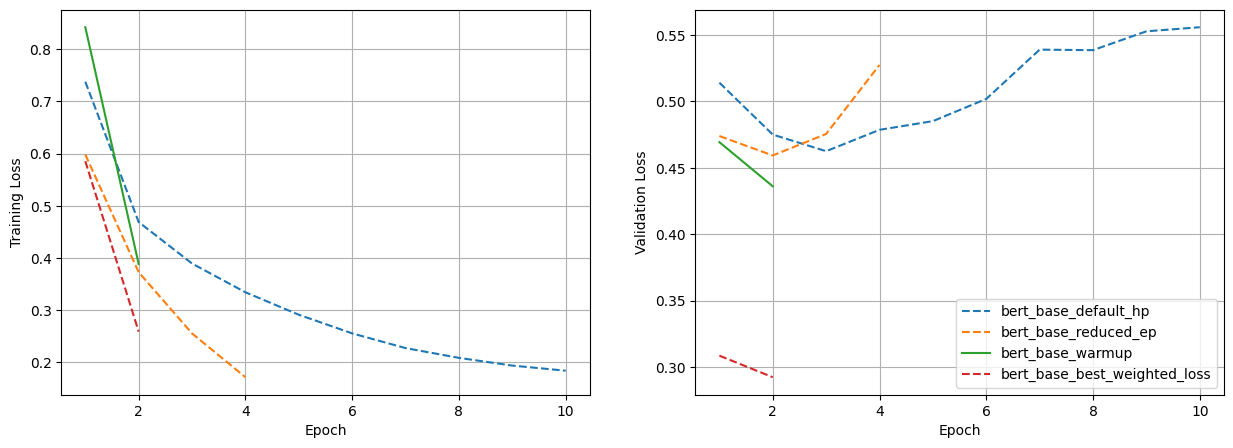

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = list(range(1, 11))
for k, (losses, val_losses) in all_experiments.items():
    num_epochs = len(losses)
    if k.startswith('bert'):
        style = "solid" if k == 'bert_base_warmup' else 'dashed'
        axes[0].plot(epochs[:num_epochs], losses, label=k, linestyle=style)
        axes[1].plot(epochs[:num_epochs], val_losses, label=k, linestyle=style)
    
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')

plt.legend()
axes[0].grid()
axes[1].grid()

## Category analisys

C:\Studying\BigBrother\.venv\Lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


<BarContainer object of 4 artists>

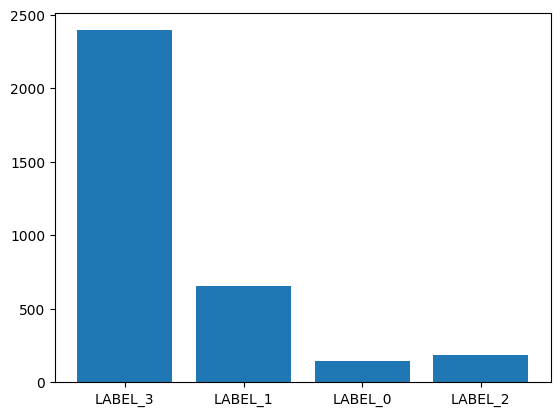

In [33]:
import numpy as np
from transformers import AutoModelForSequenceClassification, pipeline
from collections import Counter


def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('{@') or t == "{{USERNAME}}" and len(t) > 1 else t
        t = 'http' if t.startswith('http') or t == "{{URL}}" else t
        new_text.append(t)
    return " ".join(new_text)

model_name = "lucasresck/bert-base-cased-ag-news"
sentiment_task = pipeline("text-classification", model=model_name, tokenizer=model_name)

categ_preds = []
categ_scores = []
for row in test_dataset['tokens']:
    pred = sentiment_task(preprocess(' '.join(row)))[0]
    categ_preds.append(pred['label'])
    categ_scores.append(pred['score'])
    #print(' '.join(row), pred['label'])

hist = Counter(categ_preds)
plt.bar(hist.keys(), hist.values())

In [34]:
categ_df = pd.DataFrame({'label': categ_preds, 'score': categ_scores})
categ_df[categ_df['label'] == 'LABEL_2']['score'].mean()

np.float64(0.8887885756632115)

## Sentiment analisys

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


<BarContainer object of 3 artists>

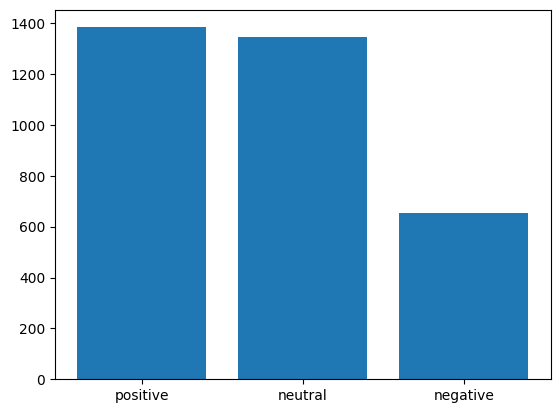

In [35]:
from transformers import pipeline
from collections import Counter


def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

sentiment_preds = []
for row in test_dataset['tokens']:
    pred = sentiment_task(preprocess(' '.join(row)))[0]
    sentiment_preds.append(pred['label'])

hist = Counter(sentiment_preds)
plt.bar(hist.keys(), hist.values())

## Labeled dataset generation example

In [36]:
save_path = "bert_base_warmup"

ner_model = torch.load(os.path.join('checkpoints', save_path, 'best_model.pth'), weights_only=False).to(device).eval()
ner_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, clean_up_tokenization_spaces=False)
ner_tokenizer.add_tokens(["{{URL}}", "{{USERNAME}}", "{@", "@}"])

test_dataset_tokenized = create_dataset(test_dataset, os.path.join(CACHE_DIR, save_path, 'test_all_tokenized.csv'), ner_tokenizer, max_len=128)
test_ner_dataset = NERDataset(test_dataset_tokenized)

model_preds = infer_model(ner_model, ner_tokenizer, test_ner_dataset, test_dataset_tokenized['word_inds'])
metrics_class, metrics_global = calculate_metrics(model_preds, test_dataset['bio_labels'])

Found cached data in data\bert_base_warmup\test_all_tokenized.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3383/3383 [00:09<00:00, 354.87it/s]


           corporation  creative_work        event        group    location  \
precision     0.491403       0.362087     0.468408     0.601319    0.616424   
recall        0.502778       0.376940     0.409426     0.551705    0.676169   
f1            0.497025       0.369364     0.436935     0.575445    0.644916   
number     1080.000000     902.000000  1358.000000  1818.000000  877.000000   

                person      product  
precision     0.798322     0.654464  
recall        0.838092     0.618565  
f1            0.817724     0.636009  
number     3292.000000  1185.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.625371        0.620909    0.623132          0.922029


In [37]:
test_data_pd = test_dataset.to_pandas()
test_data_pd.drop(columns=['tags', 'bio_labels'], inplace=True)
test_data_pd['NER_labels'] = model_preds
test_data_pd['sentiment_labels'] = sentiment_preds
test_data_pd['categ_labels'] = categ_preds
test_data_pd.to_csv('labeled_dataset.csv')